In [25]:
import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Callable, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput
from dotenv import load_dotenv
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import os
import getpass

logger = logging.getLogger(__name__)

# Simplified loading of environment variables and IBM connection parameters
load_dotenv()

def set_env(var: str):
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

class IbmConnectionParams(BaseModel):
    api_key: str
    project_id: str
    url: str
    credentials: dict[str, str]

    def __init__(self, api_key: str, project_id: str, url: str) -> None:
        super().__init__(api_key=api_key, project_id=project_id, url=url, credentials={"url": url, "apikey": api_key})

# Set IBM connection parameters
ibm_params = IbmConnectionParams(
    api_key=set_env("WATSONX_API_KEY"),
    project_id=set_env("PROJECT_ID"),
    url = set_env("WATSONX_URL")
)

parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 100,#1000,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""
    # Define the default parameters as class variables
    DEFAULT_MODEL_ID = "ibm/granite-13b-instruct-v2"
    DEFAULT_URL = ibm_params.url
    DEFAULT_APIKEY = ibm_params.api_key
    DEFAULT_PROJECT_ID = ibm_params.project_id
    DEFAULT_PARAMS = parameters    
    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, model_id: Optional[str] = None, **kwargs):
        if not model_id and 'deployment_id' not in kwargs:
            raise ValueError("One of 'model_id' or 'deployment_id' parameters should be set.")
        super().__init__(model_id=model_id, *args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
    ) -> LLMResult:
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(f"WatsonxLLM currently only supports single prompt, got {prompts}")
            generation = GenerationChunk(text="")
            stream_iter = self._stream(prompts[0], stop=stop, run_manager=run_manager, **kwargs)
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            print("Step 1 - Starting Tool Evaluation")
                        
            if self.bound_tools:
                print("Step 1.1 self.bound_tools")
                print("type(self.bound_tools)", type(self.bound_tools)) 
                print("self.bound_tools", self.bound_tools)
                
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                logger.info("Tool output: %s", tool_output)

                system_prompt = (
                    f"You are an assistant with access to web search results. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Web Search Results: {tool_output}\n\n"
                )
                prompts[0] = system_prompt

            print("prompts", prompts)

            if not isinstance(params, dict):
                raise ValueError(f"Expected params to be a dictionary, got {type(params)}")

            response = self.watsonx_model.generate(prompt=prompts, params=params, **kwargs)
            return self._create_llm_result(response)


    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        combined_output = []
        print(f"Debug: Starting tool evaluation for input: {input_text}")
        print("tool_instances:", tool_instances)

        for tool in tool_instances:
            try:
                # Invoke the tool with the provided input
                result = tool.invoke(input_text)
                print(f"Debug: Result from tool {tool.name}: {result}")

                # Check the type of result and handle it accordingly
                if isinstance(result, str):
                    content = f"WebSearch Results: {result}"
                elif isinstance(result, list) and all(isinstance(item, dict) for item in result):
                    content = "WebSearch Results: " + " ".join(item.get('content', '') for item in result)
                elif isinstance(result, dict):
                    content = "WebSearch Results: " + result.get('content', 'Unknown response format')
                else:
                    content = "WebSearch Results: Invalid format received from tool"

                # Append the processed content to the combined output
                combined_output.append(content)

            except Exception as e:
                error_message = f"Error invoking tool {tool.name}: {str(e)}"
                print(f"Debug: {error_message}")
                combined_output.append(error_message)

        final_output = "\n\n".join(combined_output)
        print(f"Debug: Final combined output: {final_output}")
        return final_output

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        model_id: Optional[str] = None,
        url: Optional[str] = None,
        apikey: Optional[str] = None,
        project_id: Optional[str] = None,
        params: Optional[Dict[str, Any]] = None,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        # Initialize WatsonxLLM with the provided parameters
        instance = cls(
            model_id=model_id,
            url=url,
            apikey=apikey,
            project_id=project_id,
            params=params,
            **kwargs
        )
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)

# Example usage:
tool = TavilySearchResults(max_results=4)

# Bind the tool and pass all necessary parameters inside `bind_tools`
llm_with_tools = WatsonxLLM.bind_tools(
    tools=[tool],
    model_id="ibm/granite-13b-instruct-v2",
    url=ibm_params.url,
    apikey=ibm_params.api_key,
    project_id=ibm_params.project_id,
    params=parameters
)
# Invoke the model
#response = llm_with_tools.invoke("Who is Ruslan Magana?")
#print(response)


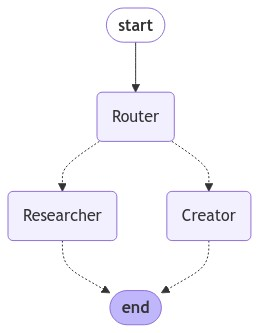

{'Router': {'messages': [HumanMessage(content='Fetch the bitcoin price over the past 5 days.')], 'sender': None}}
----
{'Researcher': {'messages': [AIMessage(content="Researcher Agent: Fetched data for 'Fetch the bitcoin price over the past 5 days.'", name='Researcher')], 'sender': 'Researcher'}}
----
Final


In [24]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
import functools
from typing_extensions import TypedDict
from typing import Sequence
from IPython.display import Image, display

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Simplified agent function
def simple_agent(agent_type: str, message: str):
    """Simulate agent response based on agent type."""
    if agent_type == "Researcher":
        return f"Researcher Agent: Fetched data for '{message}'"
    else:
        return f"Creator Agent: Generated response for '{message}'"

# Router to determine the agent based on message content
def router(state) -> str:
    """Route to either 'Researcher' or 'Creator' based on the message content."""
    last_message = state["messages"][-1].content
    if "price" in last_message or "latest" in last_message:
        return "Researcher"
    else:
        return "Creator"

# Researcher Agent Node
def researcher_agent_node(state, name):
    result = simple_agent("Researcher", state["messages"][-1].content)
    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Creator Agent Node
def creator_agent_node(state, name):
    result = simple_agent("Creator", state["messages"][-1].content)
    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Summarizer Agent Node (optional if needed)
def summarizer_agent_node(state, name):
    result = "SUMMARY: " + state["messages"][-1].content
    return {
        "messages": [AIMessage(content=result, name=name)],
        "sender": name,
    }

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, name="Researcher")
creator_node = functools.partial(creator_agent_node, name="Creator")

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Creator", creator_node)

# Add Router as an explicit node
workflow.add_node("Router", lambda state: state)

# Routing decisions based on the router function
workflow.add_conditional_edges("Router", router, {"Researcher": "Researcher", "Creator": "Creator"})

# After either Researcher or Creator is done, the program ends
workflow.add_conditional_edges("Researcher", lambda state: "__end__", {"__end__": END})
workflow.add_conditional_edges("Creator", lambda state: "__end__", {"__end__": END})

# Set entry point
workflow.set_entry_point("Router")

# Compile the workflow for execution
graph = workflow.compile()

# Function to display the architecture
def display_architecture():
    """Display the graph architecture."""
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except:
        print("Unable to display graph architecture. Extra dependencies might be missing.")

# Function to evaluate a message and run the system
def evaluate_message(message: str):
    """Evaluate the message and route it through the system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )
    
    for s in events:
        print(s)
        print("----")
    print("Final")

# Display the architecture
display_architecture()

# Example call to test the system
evaluate_message("Fetch the bitcoin price over the past 5 days.")


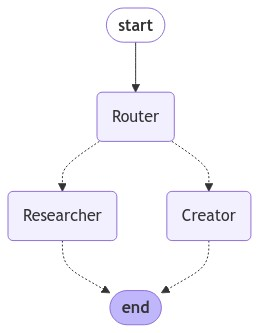

{'Router': {'messages': [HumanMessage(content='Fetch the bitcoin price over the past 5 days.')], 'sender': None}}
----
{'Researcher': {'messages': [AIMessage(content='Researcher Agent: Fetched search results for \'Fetch the bitcoin price over the past 5 days.\': [{\'url\': \'https://www.investing.com/crypto/bitcoin/historical-data\', \'content\': "Bitcoin Historical Data. Get historical data for the Bitcoin prices. You\'ll find the historical Bitcoin market data for the selected range of dates. The data can be viewed in daily, weekly or ..."}, {\'url\': \'https://www.coindesk.com/price/bitcoin\', \'content\': \'The price of Bitcoin (BTC) is $63,646.70 today, as of Oct 07 08:12 a.m., with a 24-hour trading volume of $19.72B. Over the last 24 hours, the price has increased by 2.77%. Bitcoin currently has a ...\'}, {\'url\': \'https://coincodex.com/crypto/bitcoin/historical-data/\', \'content\': "Access the entire Bitcoin value history - simply select the time range you\'re interested in 

/mnt/c/Blog/WatsonX-Multi-Agent-System-with-Langraph/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(


{'Creator': {'messages': [AIMessage(content='Creator Agent: Bitcoin is a digital currency that was created in 2009 by an unknown person or group of people using the pseudonym Satoshi Nakamoto. It is a decentralized form of currency, meaning that it is not controlled by any government or financial institution.\n\nBitcoin transactions are recorded on a public ledger called the blockchain, which is maintained by a network of computers called nodes. Transactions are verified by these nodes through a process called mining, where complex mathematical problems are solved in order to add new blocks to the blockchain.\n\nOne of the key features of Bitcoin is its limited supply. There will only ever be 21 million Bitcoins in existence, which makes it a deflationary currency. This scarcity has led to Bitcoin being used as a store of value and a hedge against inflation.\n\nBitcoin can be used to make purchases online or in person, and it can also be traded on various cryptocurrency exchanges. It h

In [27]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
from IPython.display import Image, display
from typing_extensions import TypedDict
from typing import Sequence
import functools

# Load environment variables from .env file
load_dotenv()

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Tool Initialization for the Researcher
tavily_tool = TavilySearchResults(max_results=5)  # Tool to fetch search results from the internet

# Load OpenAI API key from environment variable
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("Please set the OPENAI_API_KEY in your .env file.")

# Define LLM model for the Creator using OpenAI with the loaded API key
llm_creator = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7, openai_api_key=openai_api_key)

# Router to determine the agent based on message content
def router(state) -> str:
    """Route to either 'Researcher' or 'Creator' based on the message content."""
    last_message = state["messages"][-1].content
    if "price" in last_message or "latest" in last_message:
        return "Researcher"
    else:
        return "Creator"

# Researcher Agent Node
def researcher_agent_node(state, name):
    """Researcher agent that fetches data from the internet."""
    query = state["messages"][-1].content
    search_results = tavily_tool.invoke(query)  # Perform search
    result = f"Researcher Agent: Fetched search results for '{query}': {search_results}"
    return {
        "messages": [AIMessage(content=result, name=name)],
        "sender": name,
    }

# Creator Agent Node (LLM)
def creator_agent_node(state, name):
    """Creator agent that uses a language model to generate responses."""
    query = state["messages"][-1].content
    result = llm_creator.predict(query)  # Generate response using the LLM
    return {
        "messages": [AIMessage(content=f"Creator Agent: {result}", name=name)],
        "sender": name,
    }

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, name="Researcher")
creator_node = functools.partial(creator_agent_node, name="Creator")

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Creator", creator_node)

# Add Router as an explicit node
workflow.add_node("Router", lambda state: state)

# Routing decisions based on the router function
workflow.add_conditional_edges("Router", router, {"Researcher": "Researcher", "Creator": "Creator"})

# After either Researcher or Creator is done, the program ends
workflow.add_conditional_edges("Researcher", lambda state: "__end__", {"__end__": END})
workflow.add_conditional_edges("Creator", lambda state: "__end__", {"__end__": END})

# Set entry point
workflow.set_entry_point("Router")

# Compile the workflow for execution
graph = workflow.compile()

# Function to display the architecture
def display_architecture():
    """Display the graph architecture."""
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except:
        print("Unable to display graph architecture. Extra dependencies might be missing.")

# Function to evaluate a message and run the system
def evaluate_message(message: str):
    """Evaluate the message and route it through the system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )
    
    for s in events:
        print(s)
        print("----")
    print("Final")

# Display the architecture
display_architecture()

# Example call to test the system
evaluate_message("Fetch the bitcoin price over the past 5 days.")  # Researcher case
evaluate_message("Explain what Bitcoin is.")  # Creator case


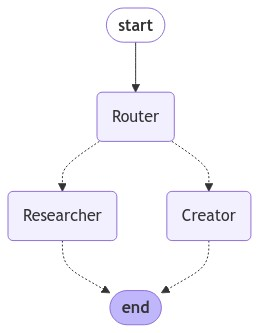

{'Router': {'messages': [AIMessage(content='Router Agent: Selected Researcher', name='Router')], 'sender': 'Router'}}
----
{'Researcher': {'messages': [AIMessage(content='Researcher Agent: Fetched search results for \'Router Agent: Selected Researcher\': [{\'url\': \'https://github.com/PatrickAttankurugu/Agentic-RAG-with-Llamaindex\', \'content\': \'Building basic agents that can select relevant documents based on user queries. Developing router agents for tasks like Q&A and summarization. Extending research agents to handle multiple documents. Debugging and controlling agents to ensure accurate and efficient performance.\'}, {\'url\': \'https://docs.llamaindex.ai/en/stable/module_guides/querying/router/\', \'content\': \'Routers are modules that take in a user query and a set of "choices" (defined by metadata), and returns one or more selected choices. They can be used on their own (as "selector modules"), or used as a query engine or retriever (e.g. on top of other query engines/retr

In [31]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
from IPython.display import Image, display
from typing_extensions import TypedDict
from typing import Sequence
import functools

# Load environment variables from .env file
load_dotenv()

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Tool Initialization for the Researcher
tavily_tool = TavilySearchResults(max_results=5)  # Tool to fetch search results from the internet

# Load OpenAI API key from environment variable
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("Please set the OPENAI_API_KEY in your .env file.")

# Define LLM model for the Creator using OpenAI with the loaded API key
llm_creator = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7, openai_api_key=openai_api_key)

# Define LLM model for the Router (which will select the agent)
llm_router = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.3, openai_api_key=openai_api_key)

# Router Agent Node (LLM-based)
def router_agent_node(state, name):
    """Router agent that selects either 'Researcher' or 'Creator' based on the message."""
    query = state["messages"][-1].content
    
    # Router prompt that instructs the LLM to choose the appropriate agent
    router_prompt = (
        "You are a routing agent. Your task is to select one of two agents based on the user input.\n"
        "If the user query is about recent information or data like prices, select 'Researcher'.\n"
        "If the user query is more general or requires a knowledge-based response, select 'Creator'.\n\n"
        f"User Query: {query}\n\n"
        "Answer with only one word: 'Researcher' or 'Creator'."
    )
    
    # Generate the response using the LLM
    selected_agent = llm_router.predict(router_prompt).strip()
    
    return {
        "messages": [AIMessage(content=f"Router Agent: Selected {selected_agent}", name=name)],
        "sender": name,
        "selected_agent": selected_agent,  # Include the selected agent in the state
    }

# Researcher Agent Node
def researcher_agent_node(state, name):
    """Researcher agent that fetches data from the internet."""
    query = state["messages"][-1].content
    search_results = tavily_tool.invoke(query)  # Perform search
    result = f"Researcher Agent: Fetched search results for '{query}': {search_results}"
    return {
        "messages": [AIMessage(content=result, name=name)],
        "sender": name,
    }

# Creator Agent Node (LLM)
def creator_agent_node(state, name):
    """Creator agent that uses a language model to generate responses."""
    query = state["messages"][-1].content
    result = llm_creator.predict(query)  # Generate response using the LLM
    return {
        "messages": [AIMessage(content=f"Creator Agent: {result}", name=name)],
        "sender": name,
    }

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, name="Researcher")
creator_node = functools.partial(creator_agent_node, name="Creator")

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Router", functools.partial(router_agent_node, name="Router"))
workflow.add_node("Researcher", research_node)
workflow.add_node("Creator", creator_node)

# Routing logic based on Router Agent's decision
def extract_selected_agent(state) -> str:
    """Extracts the selected agent ('Researcher' or 'Creator') from the Router agent's response."""
    return state["selected_agent"]

# Add conditional edges based on the Router agent's response
workflow.add_conditional_edges("Router", extract_selected_agent, {"Researcher": "Researcher", "Creator": "Creator"})

# After either Researcher or Creator is done, the program ends
workflow.add_conditional_edges("Researcher", lambda state: "__end__", {"__end__": END})
workflow.add_conditional_edges("Creator", lambda state: "__end__", {"__end__": END})

# Set entry point
workflow.set_entry_point("Router")

# Compile the workflow for execution
graph = workflow.compile()

# Function to display the architecture
def display_architecture():
    """Display the graph architecture."""
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except:
        print("Unable to display graph architecture. Extra dependencies might be missing.")

# Function to evaluate a message and run the system
def evaluate_message(message: str):
    """Evaluate the message and route it through the system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )
    
    for s in events:
        print(s)
        print("----")
    print("Final")

# Display the architecture
display_architecture()

# Example call to test the system
evaluate_message("Fetch the bitcoin price over the past 5 days.")  # Researcher case
evaluate_message("Explain what Bitcoin is.")  # Creator case


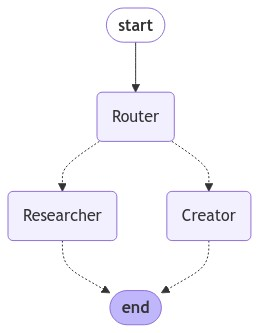

{'Router': {'messages': [AIMessage(content='Router Agent: Selected Researcher', name='Router')], 'sender': 'Router', 'user_query': 'Fetch the bitcoin price over the past 5 days.'}}
----
{'Researcher': {'messages': [AIMessage(content='Researcher Agent: Fetched search results for \'Fetch the bitcoin price over the past 5 days.\': [{\'url\': \'https://www.coindesk.com/price/bitcoin\', \'content\': \'The price of Bitcoin (BTC) is $63,646.70 today, as of Oct 07 08:12 a.m., with a 24-hour trading volume of $19.72B. Over the last 24 hours, the price has increased by 2.77%. Bitcoin currently has a ...\'}, {\'url\': \'https://www.google.com/finance/quote/BTC-usd\', \'content\': \'62,083.00. About Bitcoin. . Get the latest Bitcoin (BTC / USD) real-time quote, historical performance, charts, and other cryptocurrency information to help you make more informed trading and ...\'}, {\'url\': \'https://coincodex.com/crypto/bitcoin/historical-data/\', \'content\': "Access the entire Bitcoin value histo

In [33]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
from IPython.display import Image, display
from typing_extensions import TypedDict
from typing import Sequence
import functools

# Load environment variables from .env file
load_dotenv()

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str
    user_query: str  # Add user_query to the AgentState

# Tool Initialization for the Researcher
tavily_tool = TavilySearchResults(max_results=5)  # Tool to fetch search results from the internet

# Load OpenAI API key from environment variable
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("Please set the OPENAI_API_KEY in your .env file.")

# Define LLM model for the Creator using OpenAI with the loaded API key
llm_creator = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7, openai_api_key=openai_api_key)

# Define LLM model for the Router (which will select the agent)
llm_router = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.3, openai_api_key=openai_api_key)

# Router Agent Node (LLM-based)
def router_agent_node(state, name):
    """Router agent that selects either 'Researcher' or 'Creator' based on the message."""
    query = state["messages"][-1].content
    
    # Router prompt that instructs the LLM to choose the appropriate agent
    router_prompt = (
        "You are a routing agent. Your task is to select one of two agents based on the user input.\n"
        "If the user query is about recent information or data like prices, select 'Researcher'.\n"
        "If the user query is more general or requires a knowledge-based response, select 'Creator'.\n\n"
        f"User Query: {query}\n\n"
        "Answer with only one word: 'Researcher' or 'Creator'."
    )
    
    # Generate the response using the LLM
    selected_agent = llm_router.predict(router_prompt).strip()
    
    return {
        "messages": [AIMessage(content=f"Router Agent: Selected {selected_agent}", name=name)],
        "sender": name,
        "selected_agent": selected_agent,  # Include the selected agent in the state
        "user_query": query,  # Store the user query in the state
    }

# Researcher Agent Node
def researcher_agent_node(state, name):
    """Researcher agent that fetches data from the internet."""
    query = state["user_query"]  # Access user_query from the state
    search_results = tavily_tool.invoke(query)  # Perform search
    result = f"Researcher Agent: Fetched search results for '{query}': {search_results}"
    return {
        "messages": [AIMessage(content=result, name=name)],
        "sender": name,
    }

# Creator Agent Node (LLM)
def creator_agent_node(state, name):
    """Creator agent that uses a language model to generate responses."""
    query = state["user_query"]  # Access user_query from the state
    # Include the user query in the prompt for the Creator
    creator_prompt = f"Please answer the following query: {query}" 
    result = llm_creator.predict(creator_prompt)  # Generate response using the LLM
    return {
        "messages": [AIMessage(content=f"Creator Agent: {result}", name=name)],
        "sender": name,
    }

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, name="Researcher")
creator_node = functools.partial(creator_agent_node, name="Creator")

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Router", functools.partial(router_agent_node, name="Router"))
workflow.add_node("Researcher", research_node)
workflow.add_node("Creator", creator_node)

# Routing logic based on Router Agent's decision
def extract_selected_agent(state) -> str:
    """Extracts the selected agent ('Researcher' or 'Creator') from the Router agent's response."""
    return state["selected_agent"]

# Add conditional edges based on the Router agent's response
workflow.add_conditional_edges("Router", extract_selected_agent, {"Researcher": "Researcher", "Creator": "Creator"})

# After either Researcher or Creator is done, the program ends
workflow.add_conditional_edges("Researcher", lambda state: "__end__", {"__end__": END})
workflow.add_conditional_edges("Creator", lambda state: "__end__", {"__end__": END})

# Set entry point
workflow.set_entry_point("Router")

# Compile the workflow for execution
graph = workflow.compile()

# Function to display the architecture
def display_architecture():
    """Display the graph architecture."""
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except:
        print("Unable to display graph architecture. Extra dependencies might be missing.")

# Function to evaluate a message and run the system
def evaluate_message(message: str):
    """Evaluate the message and route it through the system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )
    
    for s in events:
        print(s)
        print("----")
    print("Final")

# Display the architecture
display_architecture()

# Example call to test the system
evaluate_message("Fetch the bitcoin price over the past 5 days.")  # Researcher case
evaluate_message("Explain what Bitcoin is.")  # Creator case

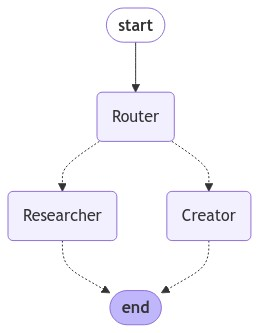

{'Router': {'messages': [AIMessage(content='Router Agent: Selected Researcher', name='Router')], 'sender': 'Router'}}
----
{'Researcher': {'messages': [AIMessage(content='Researcher Agent: Fetched search results for \'Router Agent: Selected Researcher\': [{\'url\': \'https://github.com/PatrickAttankurugu/Agentic-RAG-with-Llamaindex\', \'content\': \'Building basic agents that can select relevant documents based on user queries. Developing router agents for tasks like Q&A and summarization. Extending research agents to handle multiple documents. Debugging and controlling agents to ensure accurate and efficient performance.\'}, {\'url\': \'https://github.com/LakshitaS/Agentic-RAG-implementation\', \'content\': \'Objective: Enhance the router agent so that it can not only select a function to execute but also determine the appropriate parameters or arguments for that function. Implementation: The agent will utilize an LLM (Large Language Model) to understand the query context and infer ne

In [32]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
from IPython.display import Image, display
from typing_extensions import TypedDict
from typing import Sequence
import functools

# Load environment variables from .env file
load_dotenv()

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Tool Initialization for the Researcher
tavily_tool = TavilySearchResults(max_results=5)  # Tool to fetch search results from the internet

# Load OpenAI API key from environment variable
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("Please set the OPENAI_API_KEY in your .env file.")

# Define LLM model for the Creator using OpenAI with the loaded API key
llm_creator = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7, openai_api_key=openai_api_key)

# Define LLM model for the Router (which will select the agent)
llm_router = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.3, openai_api_key=openai_api_key)

# Router Agent Node (LLM-based)
def router_agent_node(state, name):
    """Router agent that selects either 'Researcher' or 'Creator' based on the message."""
    query = state["messages"][-1].content
    
    # Router prompt that instructs the LLM to choose the appropriate agent
    router_prompt = (
        "You are a routing agent. Your task is to select one of two agents based on the user input.\n"
        "If the user query is about recent information or data like prices, select 'Researcher'.\n"
        "If the user query is more general or requires a knowledge-based response, select 'Creator'.\n\n"
        f"User Query: {query}\n\n"
        "Answer with only one word: 'Researcher' or 'Creator'."
    )
    
    # Generate the response using the LLM
    selected_agent = llm_router.predict(router_prompt).strip()
    
    return {
        "messages": [AIMessage(content=f"Router Agent: Selected {selected_agent}", name=name)],
        "sender": name,
        "selected_agent": selected_agent,  # Include the selected agent in the state
    }

# Researcher Agent Node
def researcher_agent_node(state, name):
    """Researcher agent that fetches data from the internet."""
    query = state["messages"][-1].content  # Forward the original user message
    search_results = tavily_tool.invoke(query)  # Perform search
    result = f"Researcher Agent: Fetched search results for '{query}': {search_results}"
    return {
        "messages": [AIMessage(content=result, name=name)],
        "sender": name,
    }

# Creator Agent Node (LLM)
def creator_agent_node(state, name):
    """Creator agent that uses a language model to generate responses."""
    query = state["messages"][-1].content  # Forward the original user message
    result = llm_creator.predict(query)  # Generate response using the LLM
    return {
        "messages": [AIMessage(content=f"Creator Agent: {result}", name=name)],
        "sender": name,
    }

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, name="Researcher")
creator_node = functools.partial(creator_agent_node, name="Creator")

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Router", functools.partial(router_agent_node, name="Router"))
workflow.add_node("Researcher", research_node)
workflow.add_node("Creator", creator_node)

# Routing logic based on Router Agent's decision
def extract_selected_agent(state) -> str:
    """Extracts the selected agent ('Researcher' or 'Creator') from the Router agent's response."""
    return state["selected_agent"]

# Add conditional edges based on the Router agent's response
workflow.add_conditional_edges("Router", extract_selected_agent, {"Researcher": "Researcher", "Creator": "Creator"})

# After either Researcher or Creator is done, the program ends
workflow.add_conditional_edges("Researcher", lambda state: "__end__", {"__end__": END})
workflow.add_conditional_edges("Creator", lambda state: "__end__", {"__end__": END})

# Set entry point
workflow.set_entry_point("Router")

# Compile the workflow for execution
graph = workflow.compile()

# Function to display the architecture
def display_architecture():
    """Display the graph architecture."""
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except:
        print("Unable to display graph architecture. Extra dependencies might be missing.")

# Function to evaluate a message and run the system
def evaluate_message(message: str):
    """Evaluate the message and route it through the system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)  # This is the user message passed to Router
            ]
        },
        {"recursion_limit": 50}
    )
    
    for s in events:
        print(s)
        print("----")
    print("Final")

# Display the architecture
display_architecture()

# Example call to test the system
evaluate_message("Fetch the bitcoin price over the past 5 days.")  # Researcher case
evaluate_message("Explain what Bitcoin is.")  # Creator case


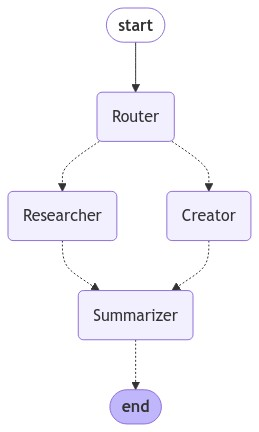

In [10]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph, START
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
import functools
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Sequence
from IPython.display import Image, display

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Tool Initialization
tavily_tool = TavilySearchResults(max_results=5)  # Research tool to fetch Bitcoin prices

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful AI assistant. Use the provided tools to answer the question."),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message)

    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )   

# Router to determine the next step based on message content
def router(state) -> str:
    last_message = state["messages"][-1].content
    if "price" in last_message or "latest" in last_message:
        return "Researcher"
    else:
        return "Creator"

# Researcher Agent Node
def researcher_agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Creator Agent Node
def creator_agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Summarizer Agent Node
def summarizer_agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [AIMessage(content="SUMMARY: " + str(result), name=name)],
        "sender": name,
    }

# Define agents
research_agent = create_agent(WatsonxLLM, [tavily_tool], system_message="Fetch Bitcoin prices.")
creator_agent = create_agent(WatsonxLLM, [], system_message="Generate knowledge-based responses.")
summarizer_agent = create_agent(WatsonxLLM, [], system_message="Summarize the fetched data.")

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, agent=research_agent, name="Researcher")
creator_node = functools.partial(creator_agent_node, agent=creator_agent, name="Creator")
summarizer_node = functools.partial(summarizer_agent_node, agent=summarizer_agent, name="Summarizer")

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Creator", creator_node)
workflow.add_node("Summarizer", summarizer_node)

# Add Router as an explicit node
workflow.add_node("Router", lambda state: state)  # A placeholder node for routing decisions

# Routing decisions based on the router function
workflow.add_conditional_edges("Router", router, {"Researcher": "Researcher", "Creator": "Creator"})
workflow.add_conditional_edges("Researcher", router, {"Summarizer": "Summarizer"})
workflow.add_conditional_edges("Creator", router, {"Summarizer": "Summarizer"})
workflow.add_conditional_edges("Summarizer", router, {"__end__": END})

# Set entry point
workflow.set_entry_point("Router")

# Compile the workflow for execution
graph = workflow.compile()

# Function to display the architecture
def display_architecture():
    """Display the graph architecture."""
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except:
        print("Unable to display graph architecture. Extra dependencies might be missing.")

# Function to evaluate a message and run the multi-agent system
def evaluate_message(message: str):
    """Evaluate the message and route it through the system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )
    
    for s in events:
        print(s)
        print("----")

# Display the architecture
display_architecture()



In [11]:
evaluate_message("Fetch the bitcoin price over the past 5 days.")


{'Router': {'messages': [HumanMessage(content='Fetch the bitcoin price over the past 5 days.')], 'sender': None}}
----
Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults()]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant. Use the provided tools to answer the question.
Human: Fetch the bitcoin price over the past 5 days.
tool_instances: [TavilySearchResults()]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://www.coingecko.com/en/coins/bitcoin/historical_data', 'content': 'Get Bitcoin (BTC) USD historical prices. Get Bitcoin (BTC) USD historical prices. Coins ... All Coins Compare Coins Converter Global Chart Exchanges Crypto Exchanges Decentralized Exchanges Derivatives NFT NFT ... 2024-10-05 $1,226,663,492,771 $30,349,059,839 $62,103 $62,092 2024-10-04 $1,200,491,237,696'}, {'url': 'https://www.statmuse.com/money/ask/bitcoin-price-chart-2024-to-202

KeyError: 'Researcher'

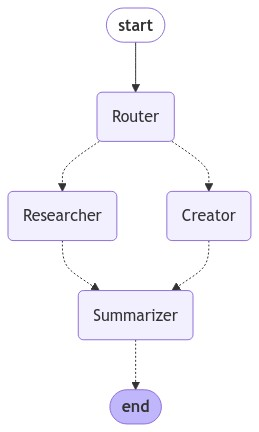

{'Router': {'messages': [HumanMessage(content='Fetch the bitcoin price over the past 5 days.')], 'sender': None}}
----
Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults()]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant. Use the provided tools to answer the question.
Human: Fetch the bitcoin price over the past 5 days.
tool_instances: [TavilySearchResults()]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://www.coingecko.com/en/coins/bitcoin/historical_data', 'content': 'Get Bitcoin (BTC) USD historical prices. Get Bitcoin (BTC) USD historical prices. Coins ... All Coins Compare Coins Converter Global Chart Exchanges Crypto Exchanges Decentralized Exchanges Derivatives NFT NFT ... 2024-10-05 $1,226,663,492,771 $30,349,059,839 $62,103 $62,092 2024-10-04 $1,200,491,237,696'}, {'url': 'https://www.statmuse.com/money/ask/bitcoin-price-chart-2024-to-202

KeyError: 'Researcher'

In [19]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph, START
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
import functools
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Sequence
from IPython.display import Image, display

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Tool Initialization
tavily_tool = TavilySearchResults(max_results=5)  # Research tool to fetch Bitcoin prices

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful AI assistant. Use the provided tools to answer the question."),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message)

    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )   

# Router to determine the next step based on message content
def router(state) -> str:
    last_message = state["messages"][-1].content
    if "price" in last_message or "latest" in last_message:
        return "Researcher"
    else:
        return "Creator"

# Researcher Agent Node
def researcher_agent_node(state, agent, name):
    result = agent.invoke(state)
    print(f"Debug: Researcher Agent invoked with result: {result}")
    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Creator Agent Node
def creator_agent_node(state, agent, name):
    result = agent.invoke(state)
    print(f"Debug: Creator Agent invoked with result: {result}")
    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Summarizer Agent Node
def summarizer_agent_node(state, agent, name):
    last_message = state["messages"][-1].content
    result = agent.invoke({"messages": [AIMessage(content=last_message)]})
    print(f"Debug: Summarizer Agent invoked with result: {result}")
    return {
        "messages": [AIMessage(content="SUMMARY: " + str(result), name=name)],
        "sender": name,
    }

# Define agents
research_agent = create_agent(WatsonxLLM, [tavily_tool], system_message="Fetch Bitcoin prices.")
creator_agent = create_agent(WatsonxLLM, [], system_message="Generate knowledge-based responses.")
summarizer_agent = create_agent(WatsonxLLM, [], system_message="Summarize the fetched data.")

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, agent=research_agent, name="Researcher")
creator_node = functools.partial(creator_agent_node, agent=creator_agent, name="Creator")
summarizer_node = functools.partial(summarizer_agent_node, agent=summarizer_agent, name="Summarizer")

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Creator", creator_node)
workflow.add_node("Summarizer", summarizer_node)

# Add Router as an explicit node
workflow.add_node("Router", lambda state: state)  # A placeholder node for routing decisions

# Routing decisions based on the router function
workflow.add_conditional_edges("Router", router, {"Researcher": "Researcher", "Creator": "Creator"})
workflow.add_conditional_edges("Researcher", router, {"Summarizer": "Summarizer"})
workflow.add_conditional_edges("Creator", router, {"Summarizer": "Summarizer"})
workflow.add_conditional_edges("Summarizer", router, {"__end__": END})

# Set entry point
workflow.set_entry_point("Router")

# Compile the workflow for execution
graph = workflow.compile()

# Function to display the architecture
def display_architecture():
    """Display the graph architecture."""
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except:
        print("Unable to display graph architecture. Extra dependencies might be missing.")

# Function to evaluate a message and run the multi-agent system
def evaluate_message(message: str):
    """Evaluate the message and route it through the system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )
    
    for s in events:
        print(s)
        print("----")

# Display the architecture
display_architecture()

# Example usage
evaluate_message("Fetch the bitcoin price over the past 5 days.")


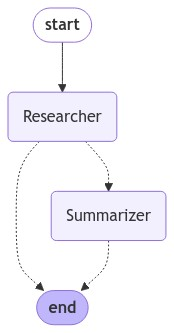

Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults()]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant. Use the provided tools to answer the question.
Human: Fetch the bitcoin price over the past 5 days.
tool_instances: [TavilySearchResults()]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://www.statmuse.com/money/ask/bitcoin-price-chart-2010-to-2024', 'content': 'The closing price for Bitcoin (BTC) between 2010 and 2024 is $62,236.66, yesterday. It is up 125,730,525% in that time. The latest price is $63,050.'}, {'url': 'https://www.investing.com/crypto/bitcoin/historical-data', 'content': "Bitcoin Historical Data. Get historical data for the Bitcoin prices. You'll find the historical Bitcoin market data for the selected range of dates. The data can be viewed in daily, weekly or ..."}, {'url': 'https://www.forbes.com/advisor/in/investing/cryptocurr

KeyError: 'Summarizer'

In [7]:
# Tool Initialization
tavily_tool = TavilySearchResults(max_results=5)  # Research tool to fetch Bitcoin prices
repl = PythonREPL()  # REPL for executing Python code (optional)

# Define the Researcher agent
def researcher_agent_node(state, agent, name):
    """Agent that researches Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Researcher Agent invoked with state: {state}")
    print(f"Debug: Research Result: {result}")

    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Define the Summarizer agent
def summarizer_agent_node(state, agent, name):
    """Agent that summarizes the fetched Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Summarizer Agent invoked with state: {state}")
    print(f"Debug: Summary Result: {result}")

    return {
        "messages": [AIMessage(content="SUMMARY: " + str(result), name=name)],
        "sender": name,
    }

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful AI assistant. Use the provided tools to answer the question."),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message)

    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Define agents
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Fetch Bitcoin prices over the last 5 days."
)
summarizer_agent = create_agent(
    WatsonxLLM, [], system_message="Summarize the fetched Bitcoin prices."
)

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, agent=research_agent, name="Researcher")
summarizer_node = functools.partial(summarizer_agent_node, agent=summarizer_agent, name="Summarizer")

# Router to determine the next step in the flow
def router(state) -> str:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    # If the last message contains research data, proceed to summarize
    if "Bitcoin" in last_message.content or "Price" in last_message.content:
        print("Debug: Routing to Summarizer")
        return "Summarizer"

    # End the process after summarization
    if "SUMMARY" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"

    return "Summarizer"

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Summarizer", summarizer_node)
workflow.add_conditional_edges("Researcher", router, {"Summarizer": "Summarizer", "__end__": END})
workflow.add_conditional_edges("Summarizer", router, {"__end__": END})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

# Function to evaluate a message and run the multi-agent system
def evaluate_message(message: str):
    """Function to evaluate the message using the multi-agent system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )

    # Output the results
    for s in events:
        print(s)
        print("----")

# Example usage of the function:
evaluate_message("Fetch the bitcoin price over the past 5 days.")


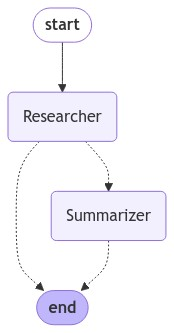

Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults()]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant. Use the provided tools to answer the question.
Human: Fetch the bitcoin price over the past 5 days.
tool_instances: [TavilySearchResults()]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://ycharts.com/indicators/bitcoin_price', 'content': 'In depth view into Bitcoin Price including historical data from 2014 to 2024, charts and stats. Bitcoin Price (I:BTCUSD) 62103.01 USD for Oct 05 2024 Overview ... Interactive Chart; More. Level Chart. Basic Info. Bitcoin Price is at a current level of 62103.01, up from 60727.86 yesterday and up from 27435.87 one year ago. ... September 09, 2024 ...'}, {'url': 'https://www.coingecko.com/en/coins/bitcoin/historical_data', 'content': 'Get Bitcoin (BTC) USD historical prices. Get Bitcoin (BTC) USD historical prices.

KeyError: 'Summarizer'

In [9]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
import functools
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated, Sequence

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Tool Initialization
tavily_tool = TavilySearchResults(max_results=5)  # Research tool to fetch Bitcoin prices
repl = PythonREPL()  # REPL for executing Python code (optional)

# Define the Researcher agent
def researcher_agent_node(state, agent, name):
    """Agent that researches Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Researcher Agent invoked with state: {state}")
    print(f"Debug: Research Result: {result}")

    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Define the Summarizer agent
def summarizer_agent_node(state, agent, name):
    """Agent that summarizes the fetched Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Summarizer Agent invoked with state: {state}")
    print(f"Debug: Summary Result: {result}")

    return {
        "messages": [AIMessage(content="SUMMARY: " + str(result), name=name)],
        "sender": name,
    }

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful AI assistant. Use the provided tools to answer the question."),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message)

    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Define agents
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Fetch Bitcoin prices over the last 5 days."
)
summarizer_agent = create_agent(
    WatsonxLLM, [], system_message="Summarize the fetched Bitcoin prices."
)

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, agent=research_agent, name="Researcher")
summarizer_node = functools.partial(summarizer_agent_node, agent=summarizer_agent, name="Summarizer")

# Router to determine the next step in the flow
def router(state) -> str:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    # If the last message contains research data, proceed to summarize
    if "Bitcoin" in last_message.content or "Price" in last_message.content:
        print("Debug: Routing to Summarizer")
        return "Summarizer"

    # End the process after summarization
    if "SUMMARY" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"

    return "Summarizer"

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Summarizer", summarizer_node)
workflow.add_conditional_edges("Researcher", router, {"Summarizer": "Summarizer", "__end__": END})
workflow.add_conditional_edges("Summarizer", router, {"__end__": END})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

# Function to evaluate a message and run the multi-agent system
def evaluate_message(message: str):
    """Function to evaluate the message using the multi-agent system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )

    # Output the results
    for s in events:
        print(s)
        print("----")

# Example usage of the function:
evaluate_message("Fetch the bitcoin price over the past 5 days.")


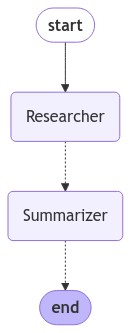

Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults()]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant. Use the provided tools to answer the question.
Human: Fetch the bitcoin price over the past 5 days.
tool_instances: [TavilySearchResults()]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://www.coingecko.com/en/coins/bitcoin/historical_data', 'content': 'Get Bitcoin (BTC) USD historical prices. Get Bitcoin (BTC) USD historical prices. ... 2024-09-10 $1,126,840,069,632 $35,655,419,448 $57,049 $57,624 2024-09-09 $1,085,390,277,574 ... $54,792 Want data in another currency? Use our API. CoinGecko Cryptocurrency Data API Proudly powering over thousands of industry builders worldwide with accurate ...'}, {'url': 'https://www.investing.com/crypto/bitcoin/historical-data', 'content': "Bitcoin Historical Data. Get historical data for the Bitcoin prices. Yo

KeyError: '__end__'

In [13]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
import functools
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated, Sequence

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Tool Initialization
tavily_tool = TavilySearchResults(max_results=5)  # Research tool to fetch Bitcoin prices
repl = PythonREPL()  # REPL for executing Python code (optional)

# Define the Researcher agent
def researcher_agent_node(state, agent, name):
    """Agent that researches Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Researcher Agent invoked with state: {state}")
    print(f"Debug: Research Result: {result}")

    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Define the Summarizer agent
def summarizer_agent_node(state, agent, name):
    """Agent that summarizes the fetched Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Summarizer Agent invoked with state: {state}")
    print(f"Debug: Summary Result: {result}")

    return {
        "messages": [AIMessage(content="SUMMARY: " + str(result), name=name)],
        "sender": name,
    }

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful AI assistant. Use the provided tools to answer the question."),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message)

    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Define agents
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Fetch Bitcoin prices over the last 5 days."
)
summarizer_agent = create_agent(
    WatsonxLLM, [], system_message="Summarize the fetched Bitcoin prices."
)

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, agent=research_agent, name="Researcher")
summarizer_node = functools.partial(summarizer_agent_node, agent=summarizer_agent, name="Summarizer")

# Router to determine the next step in the flow
def router(state) -> str:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    # If the last message contains research data, proceed to summarize
    if "Bitcoin" in last_message.content or "Price" in last_message.content:
        print("Debug: Routing to Summarizer")
        return "Summarizer"

    # End the process after summarization
    if "SUMMARY" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"

    # Default to ending if no valid content is detected
    return "__end__"


# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Summarizer", summarizer_node)

# Routing conditions after each node
workflow.add_conditional_edges("Researcher", router, {"Summarizer": "Summarizer"})
workflow.add_conditional_edges("Summarizer", router, {"__end__": END})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

# Function to evaluate a message and run the multi-agent system
def evaluate_message(message: str):
    """Function to evaluate the message using the multi-agent system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )

    # Output the results
    for s in events:
        print(s)
        print("----")

# Example usage of the function:
evaluate_message("Fetch the bitcoin price over the past 5 days.")


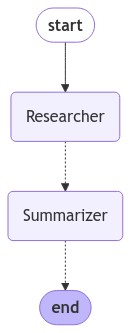

Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults()]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant. Use the provided tools to answer the question.
Human: Fetch the bitcoin price over the past 5 days.
tool_instances: [TavilySearchResults()]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://ycharts.com/indicators/bitcoin_price', 'content': 'In depth view into Bitcoin Price including historical data from 2014 to 2024, charts and stats. Bitcoin Price (I:BTCUSD) ... Interactive Chart; More. Level Chart. Basic Info. Bitcoin Price is at a current level of 62103.01, up from 60727.86 yesterday and up from 27435.87 one year ago. This is a change of 2.26% from yesterday and 126.4% from one ...'}, {'url': 'https://www.investing.com/crypto/bitcoin/historical-data', 'content': "Bitcoin Historical Data. Get historical data for the Bitcoin prices. You'll find th

KeyError: 'Summarizer'

In [14]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
import functools
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated, Sequence

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Tool Initialization
tavily_tool = TavilySearchResults(max_results=5)  # Research tool to fetch Bitcoin prices
repl = PythonREPL()  # REPL for executing Python code (optional)

# Define the Researcher agent
def researcher_agent_node(state, agent, name):
    """Agent that researches Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Researcher Agent invoked with state: {state}")
    print(f"Debug: Research Result: {result}")

    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Define the Summarizer agent
def summarizer_agent_node(state, agent, name):
    """Agent that summarizes the fetched Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Summarizer Agent invoked with state: {state}")
    print(f"Debug: Summary Result: {result}")

    return {
        "messages": [AIMessage(content="SUMMARY: " + str(result), name=name)],
        "sender": name,
    }

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful AI assistant. Use the provided tools to answer the question."),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message)

    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Define agents
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Fetch Bitcoin prices over the last 5 days."
)
summarizer_agent = create_agent(
    WatsonxLLM, [], system_message="Summarize the fetched Bitcoin prices."
)

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, agent=research_agent, name="Researcher")
summarizer_node = functools.partial(summarizer_agent_node, agent=summarizer_agent, name="Summarizer")

# Router to determine the next step in the flow
def router(state) -> str:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    # If the last message contains research data, proceed to summarize
    if "Bitcoin" in last_message.content or "Price" in last_message.content:
        print("Debug: Routing to Summarizer")
        return "Summarizer"

    # End the process after summarization
    if "SUMMARY" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"

    # Default to ending if no valid content is detected
    return "__end__"

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Summarizer", summarizer_node)

# Routing conditions after each node
workflow.add_conditional_edges("Researcher", router, {"Summarizer": "Summarizer"})
workflow.add_conditional_edges("Summarizer", router, {"__end__": END})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

# Function to evaluate a message and run the multi-agent system
def evaluate_message(message: str):
    """Function to evaluate the message using the multi-agent system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )

    # Output the results
    for s in events:
        print(s)
        print("----")

# Example usage of the function:
evaluate_message("Fetch the bitcoin price over the past 5 days.")


In [3]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
import functools
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated, Sequence

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Tool Initialization
tavily_tool = TavilySearchResults(max_results=5)  # Research tool to fetch Bitcoin prices
repl = PythonREPL()  # REPL for executing Python code (optional)

# Define the Researcher agent
def researcher_agent_node(state, agent, name):
    """Agent that researches Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Researcher Agent invoked with state: {state}")
    print(f"Debug: Research Result: {result}")

    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Define the Summarizer agent
def summarizer_agent_node(state, agent, name):
    """Agent that summarizes the fetched Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Summarizer Agent invoked with state: {state}")
    print(f"Debug: Summary Result: {result}")

    return {
        "messages": [AIMessage(content="SUMMARY: " + str(result), name=name)],
        "sender": name,
    }

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful AI assistant. Use the provided tools to answer the question."),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message)

    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Define agents
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Fetch Bitcoin prices over the last 5 days."
)
summarizer_agent = create_agent(
    WatsonxLLM, [], system_message="Summarize the fetched Bitcoin prices."
)

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, agent=research_agent, name="Researcher")
summarizer_node = functools.partial(summarizer_agent_node, agent=summarizer_agent, name="Summarizer")

# Router to determine the next step in the flow
def router(state) -> str:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    # If the last message contains research data, proceed to summarize
    if "Bitcoin" in last_message.content or "Price" in last_message.content:
        print("Debug: Routing to Summarizer")
        return "Summarizer"

    # End the process after summarization
    if "SUMMARY" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"

    # Default to ending if no valid content is detected
    return "__end__"

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Summarizer", summarizer_node)

# Routing conditions after each node
workflow.add_conditional_edges("Researcher", router, {"Summarizer": "Summarizer"})
workflow.add_conditional_edges("Summarizer", router, {"__end__": END})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

# Function to evaluate a message and run the multi-agent system
def evaluate_message(message: str):
    """Function to evaluate the message using the multi-agent system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )

    # Output the results
    for s in events:
        print(s)
        print("----")

# Example usage of the function:
evaluate_message("Fetch the bitcoin price over the past 5 days.")


AttributeError: type object 'WatsonxLLM' has no attribute 'bind_tools'